## Config

In [1]:
# Install dependencies
!pip install -q diffusers transformers torch torchvision numpy opencv-python pillow matplotlib tqdm scikit-image scipy

# Clone semantic segmentation repo and move files
!git clone https://github.com/CSAILVision/semantic-segmentation-pytorch.git
!mv semantic-segmentation-pytorch/mit_semseg .
!rm -rf semantic-segmentation-pytorch

# Download model checkpoints
import os
import urllib.request

def download_checkpoints():
    os.makedirs('ckpt/ade20k-resnet50dilated-ppm_deepsup', exist_ok=True)
    os.makedirs('data', exist_ok=True)

    files = {
        'ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth':
            'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth',
        'ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth':
            'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth'
    }

    for path, url in files.items():
        if not os.path.exists(path):
            print(f"Downloading {path}")
            urllib.request.urlretrieve(url, path)

download_checkpoints()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.4 MB/s eta 0:00:00
Cloning into 'semantic-segmentation-pytorch'...
remote: Enumerating objects: 1170, done.
remote: Total 1170 (delta 0), reused 0 (delta 0), pack-reused 1170 (from 1)
Receiving objects: 100% (1170/1170), 5

## MultiStage inpainting pipeline

In [2]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline
from skimage.metrics import structural_similarity as ssim
from mit_semseg.models import ModelBuilder, SegmentationModule
import torchvision.transforms as T
import os
from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import ipywidgets as widgets

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
def initialize_sd_pipeline():
    return StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checking=False
    ).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


### Mask generator

In [5]:
class MaskGenerator:
    def __init__(self):
        self.setup_model()
        self.background_classes = {
            'wall': 1, 'floor': 4, 'ceiling': 6,
            'windowpane': 9, 'door': 15
        }

    def setup_model(self):
        net_encoder = ModelBuilder.build_encoder(
            arch='resnet50dilated',
            fc_dim=2048,
            weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth'
        )
        net_decoder = ModelBuilder.build_decoder(
            arch='ppm_deepsup',
            fc_dim=2048,
            num_class=150,
            weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
            use_softmax=True
        )
        self.segmentation_module = SegmentationModule(
            net_encoder, net_decoder, torch.nn.NLLLoss(ignore_index=-1)
        )
        self.segmentation_module.eval()

    def generate_mask(self, image_path):
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        image = Image.open(image_path).convert('RGB')
        img_data = transform(image).unsqueeze(0)

        with torch.no_grad():
            scores = self.segmentation_module({'img_data': img_data}, segSize=img_data.shape[2:])

        pred = torch.argmax(scores, dim=1).cpu().numpy()[0]

        mask = np.ones_like(pred, dtype=np.uint8)
        for label in self.background_classes.values():
            mask[pred == label-1] = 0

        mask_path = os.path.splitext(image_path)[0] + "_foreground_mask.png"
        Image.fromarray(mask * 255).save(mask_path)

        return mask_path

## Inpainting pipeline

In [6]:
class InpaintingPipeline:
    def __init__(self, pipe):
        self.pipe = pipe
        self.setup_prompts()

    def setup_prompts(self):
        self.prompts = [
            "empty room", "empty space uniformly blank",
            "unfurnished room straight edges",
            "empty room uniformly blank straight edges",
            "completely empty room"
        ]

        self.negative_prompt = (
            "furniture, chairs, tables, beds, couches, sofas, cabinets, "
            "decorations, pillows, carpets, rugs, curtains, drapes, "
            "plants, vases, paintings, picture frames, wall art"
        )

    # def process_npz_mask(self, image_path, mask_path):
    #     empty_room = Image.open(image_path).convert('RGB').resize((512, 512))
    #     masks = np.load(mask_path)['masks']
    #     mask = np.any(masks, axis=0) if len(masks.shape) == 3 else masks
    #     mask = cv2.dilate(mask.astype(np.uint8), np.ones((3,3)), iterations=10)
    #     mask_image = Image.fromarray((mask * 255).astype(np.uint8))
    #     return empty_room, mask_image

    def process_png_mask(self, image_path, mask_path):
        empty_room = Image.open(image_path).convert('RGB').resize((512, 512))
        mask = Image.open(mask_path).convert('L').resize((512, 512))
        mask_array = np.array(mask)
        mask_array = cv2.dilate((mask_array > 127).astype(np.uint8), np.ones((3,3)), iterations=10) * 255
        return empty_room, Image.fromarray(mask_array)

    def generate_variations(self, image, mask_image, num_variations=5, seed=42):
        results = []
        for iteration in tqdm(range(num_variations), desc="Generating variations"):
            torch.manual_seed(seed + iteration) # Seed incremented for each variation
            output = self.pipe(
                prompt=self.prompts[iteration % len(self.prompts)],
                negative_prompt=self.negative_prompt,
                image=image,
                mask_image=mask_image,
                num_inference_steps=100,
                guidance_scale=7.5 + iteration * 2.5
            )
            results.append(output.images[0])
        return results

    def display_and_select(self, variations):
        from google.colab import output
        output.clear()

        plt.figure(figsize=(20, 4))
        for i, img in enumerate(variations):
            plt.subplot(1, len(variations), i + 1)
            plt.imshow(img)
            plt.title(f'Variation {i}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        from IPython.display import HTML
        from google.colab import output

        # Create HTML buttons
        buttons_html = """
        <div style="margin: 10px;">
        """
        for i in range(len(variations)):
            buttons_html += f"""
            <button id="btn_{i}"
                    style="margin: 5px; padding: 10px 20px;"
                    onclick="window.selected_variation={i}">
                Select Variation {i}
            </button>
            """
        buttons_html += "</div>"

        # JavaScript to handle selection
        js = """
        <script>
        window.selected_variation = null;
        async function wait_for_selection() {
            while (window.selected_variation === null) {
                await new Promise(r => setTimeout(r, 100));
            }
            var selection = window.selected_variation;
            window.selected_variation = null;
            return selection;
        }
        </script>
        """

        display(HTML(js + buttons_html))

        # Get selection using JavaScript evaluation
        from google.colab import output
        selection = output.eval_js('wait_for_selection()')

        print(f"Selected variation {selection}")
        return variations[selection]

    def ask_continue(self):
        from IPython.display import HTML
        from google.colab import output

        buttons_html = """
        <div style="margin: 10px;">
            <button id="btn_yes"
                    style="margin: 5px; padding: 10px 20px;"
                    onclick="window.continue_choice=true">
                Yes, generate new mask
            </button>
            <button id="btn_no"
                    style="margin: 5px; padding: 10px 20px;"
                    onclick="window.continue_choice=false">
                No, stop here
            </button>
        </div>
        """

        js = """
        <script>
        window.continue_choice = null;
        async function wait_for_continue_choice() {
            while (window.continue_choice === null) {
                await new Promise(r => setTimeout(r, 100));
            }
            var choice = window.continue_choice;
            window.continue_choice = null;
            return choice;
        }
        </script>
        """

        display(HTML(js + buttons_html))

        choice = output.eval_js('wait_for_continue_choice()')
        return choice

    def run_pipeline(self, image_path, initial_mask_path):
        print("Stage 1: Processing mask and generating variation")
        image, mask = self.process_png_mask(image_path, initial_mask_path)
        variations = self.generate_variations(image, mask)

        iteration = 1
        while True:
            clear_output(wait=True)
            print(f"Iteration {iteration}")
            selected_image = self.display_and_select(variations)
            selected_image.save(f"iteration_{iteration}.png")

            if not self.ask_continue():
                print("Pipeline completed!")
                break

            print("\nStage 2: Generating new mask")
            mask_generator = MaskGenerator()
            new_mask_path = mask_generator.generate_mask(f"iteration_{iteration}.png")

            print("\nStage 3: Processing with PNG mask")
            image, mask = self.process_png_mask(f"iteration_{iteration}.png", new_mask_path)
            variations = self.generate_variations(image, mask)
            iteration += 1


## Ingest the input

In [17]:
#@title Resources
# Install wget if not already installed
!apt-get install wget -qq

# Create directory to store the files
!mkdir -p resources

# Download and extract the ZIP of the specific branch
!wget -q https://github.com/lsunol/casalimpia/archive/refs/heads/colab/inference_sd_no_fine_tuning.zip
!unzip -q /content/inference_sd_no_fine_tuning.zip "*/resources/*"

# Move just the resources folder to your working directory
!mv casalimpia-colab-inference_sd_no_fine_tuning/models-and-research/inferance/sd_no_fine-tuning/resources/* resources/

# Clean up: remove the zip file and extracted directory
!rm -rf /content/inference_sd_no_fine_tuning.zip


In [18]:
sd_pipe = initialize_sd_pipeline()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Keyword arguments {'requires_safety_checking': False} are not expected by StableDiffusionInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
pipeline = InpaintingPipeline(sd_pipe)

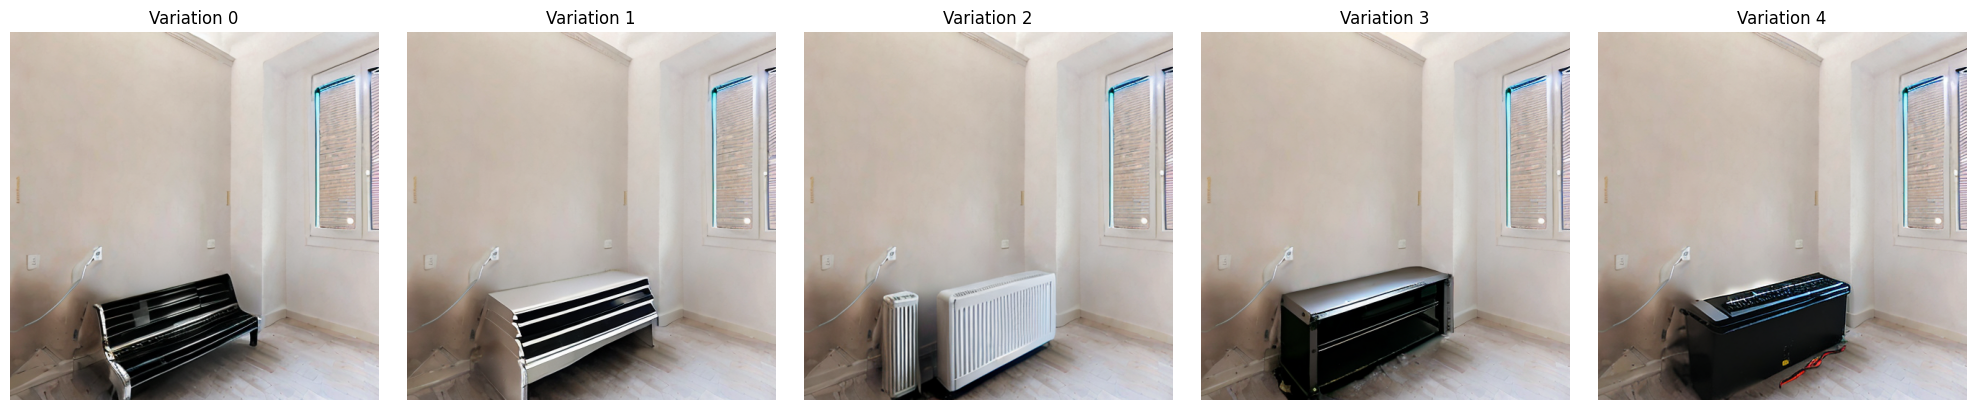

KeyboardInterrupt: 

In [21]:
pipeline.run_pipeline("/content/resources/room_objects.png", "/content/resources/room_objects_foreground_mask.png")